In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler
from torch import nn
import seaborn as sns

In [2]:
dfi = pd.read_csv('./Data/Electricity/household_power_consumption_UCIml.txt', sep=';', header=0, low_memory=False,infer_datetime_format=True,parse_dates={'datetime':[0,1]})
dfi

/tmp/ipykernel_57073/1215742683.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dfi = pd.read_csv('./Data/Electricity/household_power_consumption_UCIml.txt', sep=';', header=0, low_memory=False,infer_datetime_format=True,parse_dates={'datetime':[0,1]})


/tmp/ipykernel_57073/1215742683.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dfi = pd.read_csv('./Data/Electricity/household_power_consumption_UCIml.txt', sep=';', header=0, low_memory=False,infer_datetime_format=True,parse_dates={'datetime':[0,1]})


datetime Global_active_power Global_reactive_power  \
0       2006-12-16 17:24:00               4.216                 0.418   
1       2006-12-16 17:25:00               5.360                 0.436   
2       2006-12-16 17:26:00               5.374                 0.498   
3       2006-12-16 17:27:00               5.388                 0.502   
4       2006-12-16 17:28:00               3.666                 0.528   
...                     ...                 ...                   ...   
2075254 2010-11-26 20:58:00               0.946                 0.000   
2075255 2010-11-26 20:59:00               0.944                 0.000   
2075256 2010-11-26 21:00:00               0.938                 0.000   
2075257 2010-11-26 21:01:00               0.934                 0.000   
2075258 2010-11-26 21:02:00               0.932                 0.000   

         Voltage Global_intensity Sub_metering_1 Sub_metering_2  \
0        234.840           18.400          0.000          1.000   
1        233.630           23.000          0.000          1.000   
2        233.290           23.000          0.000          2.000   
3        233.740           23.000          0.000          1.000   
4        235.680           15.800          0.000          1.000   
...          ...              ...            ...            ...   
2075254  240.430            4.000          0.000          0.000   
2075255  240.000            4.000          0.000          0.000   
2075256  239.820            3.800          0.000          0.000   
2075257  239.700            3.800          0.000          0.000   
2075258  239.550            3.800          0.000          0.000   

         Sub_metering_3  
0                  17.0  
1                  16.0  
2                  17.0  
3                  17.0  
4                  17.0  
...                 ...  
2075254             0.0  
2075255             0.0  
2075256             0.0  
2075257             0.0  
2075258             0.0  

[2075259 rows x 8 columns]

In [3]:
# Replace '?' with missing value ('NaN') and check
dfi.replace('?', 'NaN', inplace=True)
# Convert all dtypes to float and check
dfi[['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']] = dfi[['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']].astype('float')
dfi

datetime  Global_active_power  Global_reactive_power  \
0       2006-12-16 17:24:00                4.216                  0.418   
1       2006-12-16 17:25:00                5.360                  0.436   
2       2006-12-16 17:26:00                5.374                  0.498   
3       2006-12-16 17:27:00                5.388                  0.502   
4       2006-12-16 17:28:00                3.666                  0.528   
...                     ...                  ...                    ...   
2075254 2010-11-26 20:58:00                0.946                  0.000   
2075255 2010-11-26 20:59:00                0.944                  0.000   
2075256 2010-11-26 21:00:00                0.938                  0.000   
2075257 2010-11-26 21:01:00                0.934                  0.000   
2075258 2010-11-26 21:02:00                0.932                  0.000   

         Voltage  Global_intensity  Sub_metering_1  Sub_metering_2  \
0         234.84              18.4             0.0             1.0   
1         233.63              23.0             0.0             1.0   
2         233.29              23.0             0.0             2.0   
3         233.74              23.0             0.0             1.0   
4         235.68              15.8             0.0             1.0   
...          ...               ...             ...             ...   
2075254   240.43               4.0             0.0             0.0   
2075255   240.00               4.0             0.0             0.0   
2075256   239.82               3.8             0.0             0.0   
2075257   239.70               3.8             0.0             0.0   
2075258   239.55               3.8             0.0             0.0   

         Sub_metering_3  
0                  17.0  
1                  16.0  
2                  17.0  
3                  17.0  
4                  17.0  
...                 ...  
2075254             0.0  
2075255             0.0  
2075256             0.0  
2075257             0.0  
2075258             0.0  

[2075259 rows x 8 columns]

In [4]:
dfi = dfi.groupby([pd.Grouper(freq='H', key='datetime')]).sum().reset_index()
dfi

datetime  Global_active_power  Global_reactive_power  \
0     2006-12-16 17:00:00              152.024                  8.244   
1     2006-12-16 18:00:00              217.932                  4.802   
2     2006-12-16 19:00:00              204.014                  5.114   
3     2006-12-16 20:00:00              196.114                  4.506   
4     2006-12-16 21:00:00              183.388                  4.600   
...                   ...                  ...                    ...   
34584 2010-11-26 17:00:00              103.554                  3.684   
34585 2010-11-26 18:00:00               94.408                  3.222   
34586 2010-11-26 19:00:00               99.560                  3.602   
34587 2010-11-26 20:00:00               69.822                  3.670   
34588 2010-11-26 21:00:00                2.804                  0.000   

        Voltage  Global_intensity  Sub_metering_1  Sub_metering_2  \
0       8447.18             651.6             0.0            19.0   
1      14074.81             936.0             0.0           403.0   
2      13993.95             870.2             0.0            86.0   
3      14044.29             835.0             0.0             0.0   
4      14229.52             782.8             0.0            25.0   
...         ...               ...             ...             ...   
34584  14224.18             433.0             0.0             0.0   
34585  14251.91             397.2             0.0             0.0   
34586  14204.46             423.4             0.0             4.0   
34587  14363.76             294.8             0.0            64.0   
34588    719.07              11.4             0.0             0.0   

       Sub_metering_3  
0               607.0  
1              1012.0  
2              1001.0  
3              1007.0  
4              1033.0  
...               ...  
34584           772.0  
34585             0.0  
34586             0.0  
34587             0.0  
34588             0.0  

[34589 rows x 8 columns]

In [5]:
"""The total energy consumption was larger than the sum of the 
three sub meters combined. Therefore, add a new feature 'sub_metering_4' 
will be added according to the following calculation: global_active_power * 1000/60 - (sub_metering_1 + sub_metering_2 + sub_metering_3)"""

dfi['sub_metering_4'] = (dfi.iloc[:, 1] * 1000 / 60) - (dfi.iloc[:, 5] + dfi.iloc[:, 6] + dfi.iloc[:, 7])

<Axes: >

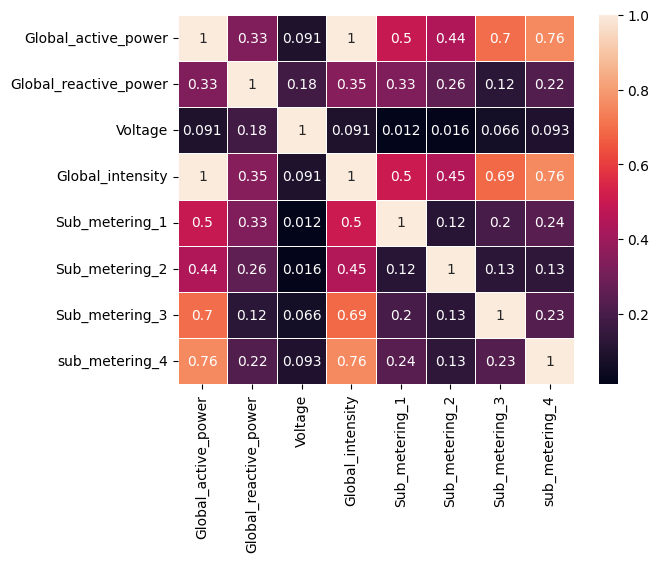

In [6]:
import seaborn as sns
corr = dfi.select_dtypes('number').corr()
sns.heatmap(data=corr, annot=True, linewidths=.5)

In [7]:
df = dfi.loc[dfi['datetime'] > '2010-06-01']
df.set_index('datetime',inplace=True)
df.drop(['Global_reactive_power','Voltage','Global_intensity'],axis=1,inplace=True)
df

/tmp/ipykernel_57073/1732557244.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Global_reactive_power','Voltage','Global_intensity'],axis=1,inplace=True)


Global_active_power  Sub_metering_1  Sub_metering_2  \
datetime                                                                   
2010-06-01 01:00:00               18.802             0.0            12.0   
2010-06-01 02:00:00               15.130             0.0            17.0   
2010-06-01 03:00:00               18.628             0.0            29.0   
2010-06-01 04:00:00               13.896             0.0             0.0   
2010-06-01 05:00:00               18.002             0.0            29.0   
...                                  ...             ...             ...   
2010-11-26 17:00:00              103.554             0.0             0.0   
2010-11-26 18:00:00               94.408             0.0             0.0   
2010-11-26 19:00:00               99.560             0.0             4.0   
2010-11-26 20:00:00               69.822             0.0            64.0   
2010-11-26 21:00:00                2.804             0.0             0.0   

                     Sub_metering_3  sub_metering_4  
datetime                                             
2010-06-01 01:00:00            88.0      213.366667  
2010-06-01 02:00:00            39.0      196.166667  
2010-06-01 03:00:00            88.0      193.466667  
2010-06-01 04:00:00            39.0      192.600000  
2010-06-01 05:00:00            87.0      184.033333  
...                             ...             ...  
2010-11-26 17:00:00           772.0      953.900000  
2010-11-26 18:00:00             0.0     1573.466667  
2010-11-26 19:00:00             0.0     1655.333333  
2010-11-26 20:00:00             0.0     1099.700000  
2010-11-26 21:00:00             0.0       46.733333  

[4293 rows x 5 columns]

In [8]:
df.ffill()

Global_active_power  Sub_metering_1  Sub_metering_2  \
datetime                                                                   
2010-06-01 01:00:00               18.802             0.0            12.0   
2010-06-01 02:00:00               15.130             0.0            17.0   
2010-06-01 03:00:00               18.628             0.0            29.0   
2010-06-01 04:00:00               13.896             0.0             0.0   
2010-06-01 05:00:00               18.002             0.0            29.0   
...                                  ...             ...             ...   
2010-11-26 17:00:00              103.554             0.0             0.0   
2010-11-26 18:00:00               94.408             0.0             0.0   
2010-11-26 19:00:00               99.560             0.0             4.0   
2010-11-26 20:00:00               69.822             0.0            64.0   
2010-11-26 21:00:00                2.804             0.0             0.0   

                     Sub_metering_3  sub_metering_4  
datetime                                             
2010-06-01 01:00:00            88.0      213.366667  
2010-06-01 02:00:00            39.0      196.166667  
2010-06-01 03:00:00            88.0      193.466667  
2010-06-01 04:00:00            39.0      192.600000  
2010-06-01 05:00:00            87.0      184.033333  
...                             ...             ...  
2010-11-26 17:00:00           772.0      953.900000  
2010-11-26 18:00:00             0.0     1573.466667  
2010-11-26 19:00:00             0.0     1655.333333  
2010-11-26 20:00:00             0.0     1099.700000  
2010-11-26 21:00:00             0.0       46.733333  

[4293 rows x 5 columns]

In [9]:
# Descriptive statistics
df.describe().T

count        mean         std  min         25%      50%  \
Global_active_power  4293.0   53.342487   43.167369  0.0   20.030000   36.782   
Sub_metering_1       4293.0   52.909154  184.318892  0.0    0.000000    0.000   
Sub_metering_2       4293.0   56.836012  176.710909  0.0    0.000000   25.000   
Sub_metering_3       4293.0  344.896110  406.169660  0.0   84.000000  102.000   
sub_metering_4       4293.0  434.400171  370.948102  0.0  203.866667  293.100   

                         75%          max  
Global_active_power   82.356   337.610000  
Sub_metering_1         0.000  2489.000000  
Sub_metering_2        47.000  2405.000000  
Sub_metering_3       605.000  1293.000000  
sub_metering_4       511.800  2473.766667

In [10]:
df = df[['Sub_metering_1','Sub_metering_2','Sub_metering_3','sub_metering_4','Global_active_power']]
df

Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                              
2010-06-01 01:00:00             0.0            12.0            88.0   
2010-06-01 02:00:00             0.0            17.0            39.0   
2010-06-01 03:00:00             0.0            29.0            88.0   
2010-06-01 04:00:00             0.0             0.0            39.0   
2010-06-01 05:00:00             0.0            29.0            87.0   
...                             ...             ...             ...   
2010-11-26 17:00:00             0.0             0.0           772.0   
2010-11-26 18:00:00             0.0             0.0             0.0   
2010-11-26 19:00:00             0.0             4.0             0.0   
2010-11-26 20:00:00             0.0            64.0             0.0   
2010-11-26 21:00:00             0.0             0.0             0.0   

                     sub_metering_4  Global_active_power  
datetime                                                  
2010-06-01 01:00:00      213.366667               18.802  
2010-06-01 02:00:00      196.166667               15.130  
2010-06-01 03:00:00      193.466667               18.628  
2010-06-01 04:00:00      192.600000               13.896  
2010-06-01 05:00:00      184.033333               18.002  
...                             ...                  ...  
2010-11-26 17:00:00      953.900000              103.554  
2010-11-26 18:00:00     1573.466667               94.408  
2010-11-26 19:00:00     1655.333333               99.560  
2010-11-26 20:00:00     1099.700000               69.822  
2010-11-26 21:00:00       46.733333                2.804  

[4293 rows x 5 columns]

# **STATISTICAL TESTS**

<Axes: xlabel='datetime'>

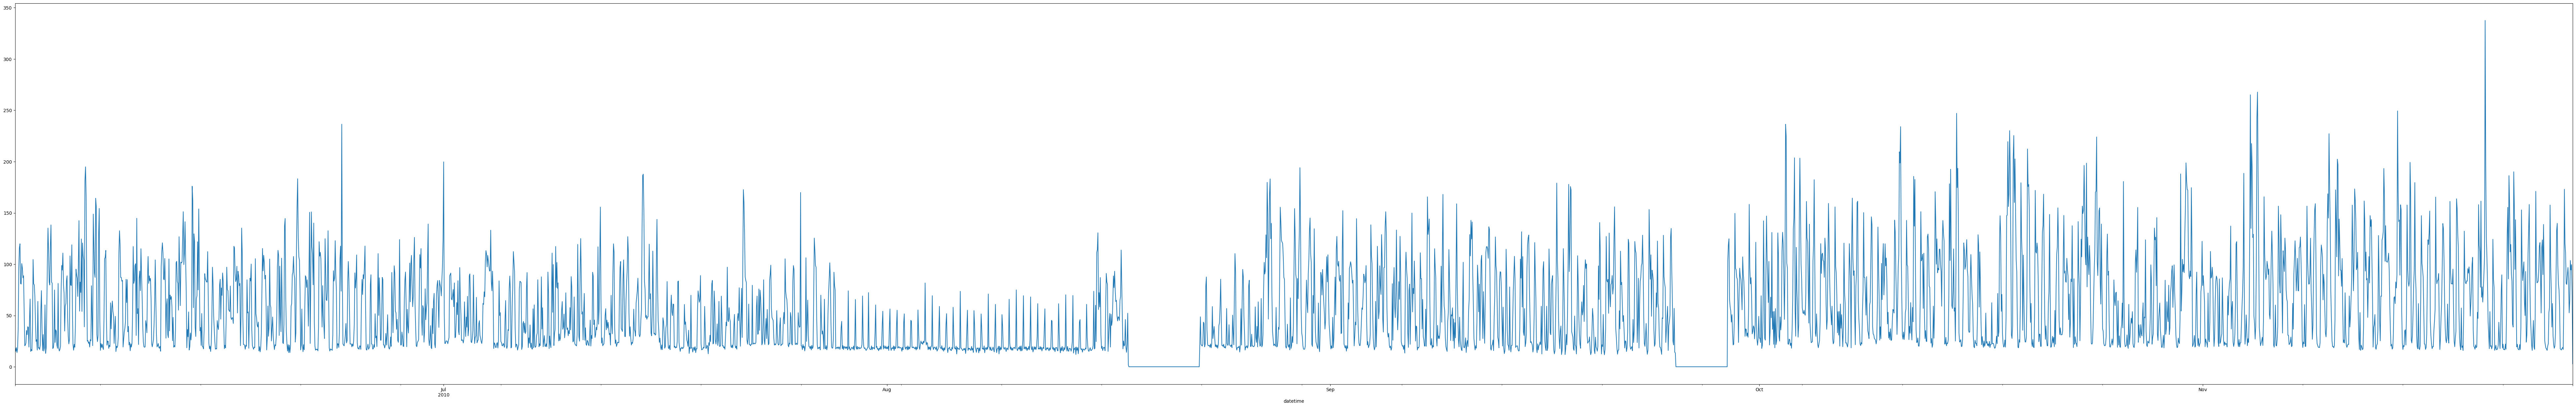

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 100, 15
df['Global_active_power'].plot()

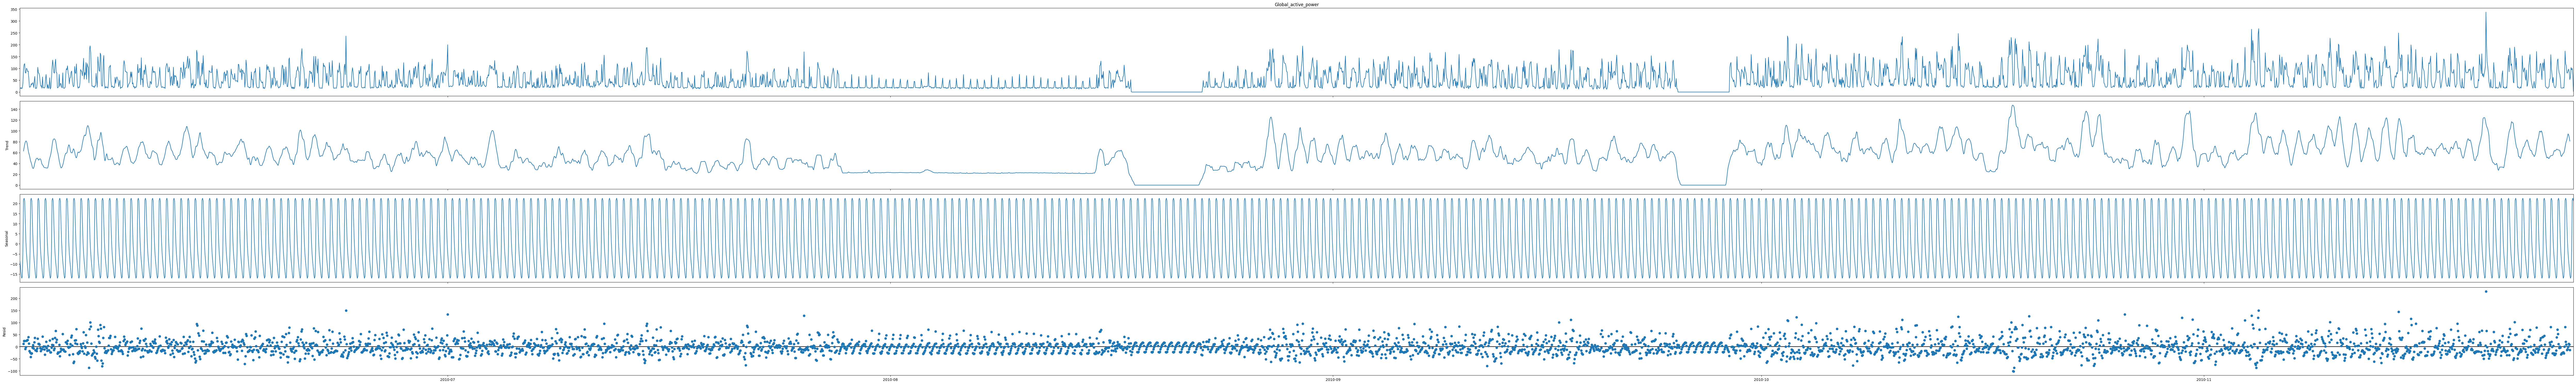

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Global_active_power'], model='additive', period=12) 
result.plot()
plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller

def adf_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

In [14]:
adf_test(df['Global_active_power'])

ADF Test Statistic : -5.62951226144258
p-value : 1.0976835181199918e-06
#Lags Used : 24
Number of Observations : 4268
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<Figure size 1200x600 with 0 Axes>

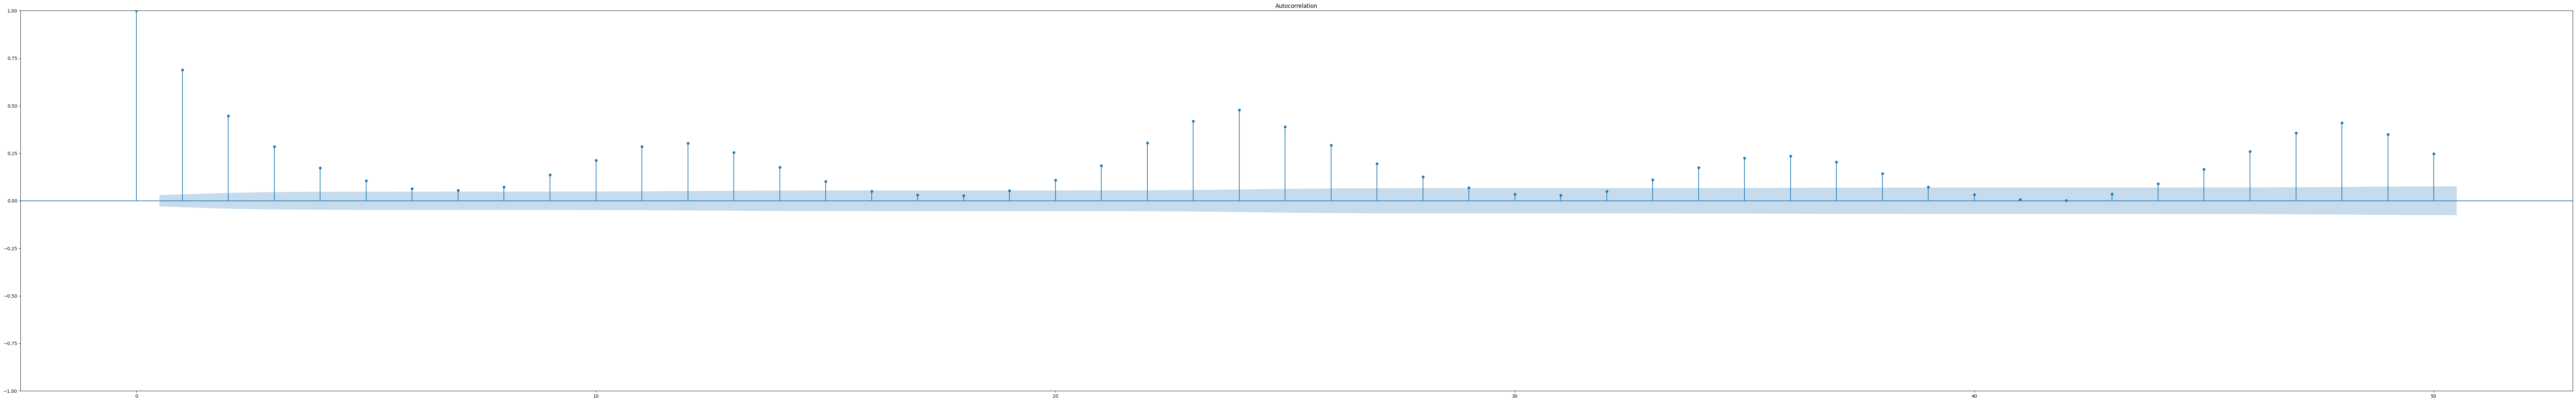

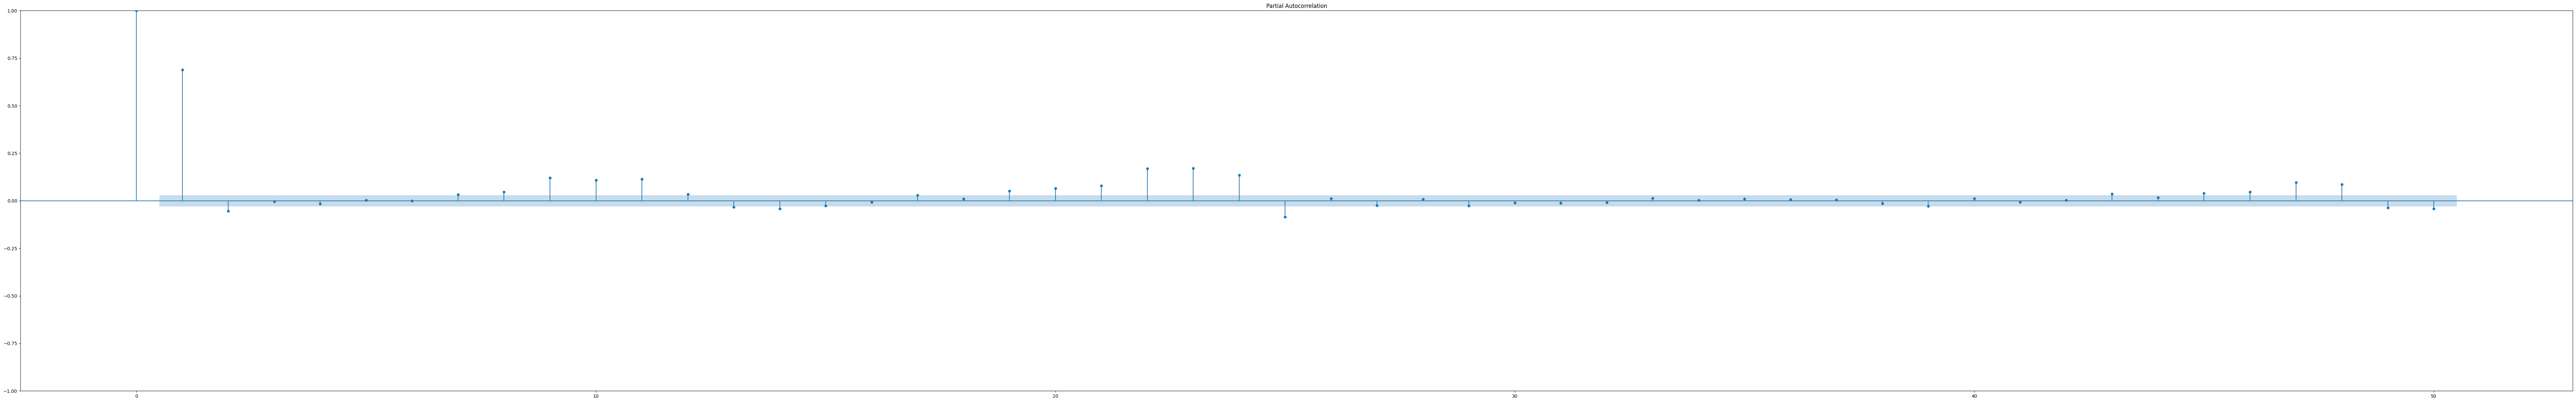

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(df['Global_active_power'], lags=50) # p = 
plot_pacf(df['Global_active_power'], lags=50) # q = 
plt.show()

# **ARIMA MODEL**

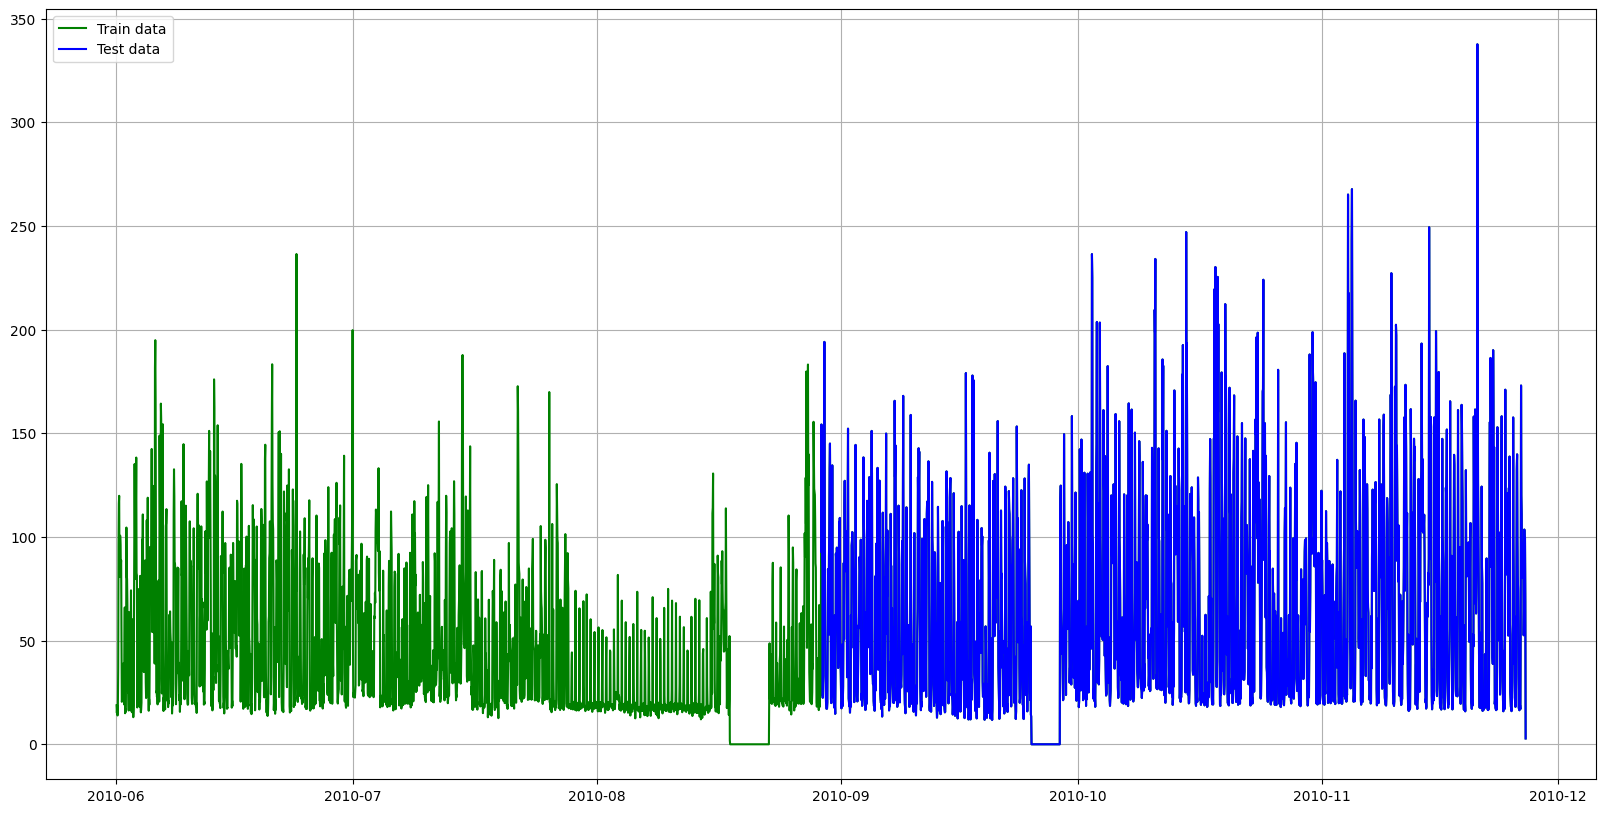

In [16]:
train_data, test_data = df[:int(len(df)*0.5)], df[int(len(df)*0.5):]
plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(df['Global_active_power'], 'green', label='Train data')
plt.plot(test_data['Global_active_power'], 'blue', label='Test data')
plt.legend()

In [17]:
'''import itertools
import warnings
warnings.filterwarnings("ignore")
q_arima = range(0, 6)
d_arima = range(0,1)
p_arima = range(0, 12)
AIC_arima = []
ARIMAX_model = []
pdqs = [(x[0], x[1], x[2]) for x in list(itertools.product(p_arima, d_arima, q_arima))]

for pdq in pdqs:
    try:
        mod = ARIMA(train_data['Global_active_power'],order=pdq)

        results = mod.fit()
        print('ARIMAX{} - AIC:{}'.format(pdq, results.aic), end='\r')
        AIC_arima.append(results.aic)
        ARIMAX_model.append([(1,1,0), pdq])
    except:
            continue
    
print('The smallest AIC is {} for model ARIMAX{}'.format(min(AIC_arima),ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]))
order_a = ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]'''

'import itertools\nimport warnings\nwarnings.filterwarnings("ignore")\nq_arima = range(0, 6)\nd_arima = range(0,1)\np_arima = range(0, 12)\nAIC_arima = []\nARIMAX_model = []\npdqs = [(x[0], x[1], x[2]) for x in list(itertools.product(p_arima, d_arima, q_arima))]\n\nfor pdq in pdqs:\n    try:\n        mod = ARIMA(train_data[\'Global_active_power\'],order=pdq)\n\n        results = mod.fit()\n        print(\'ARIMAX{} - AIC:{}\'.format(pdq, results.aic), end=\'\r\')\n        AIC_arima.append(results.aic)\n        ARIMAX_model.append([(1,1,0), pdq])\n    except:\n            continue\n    \nprint(\'The smallest AIC is {} for model ARIMAX{}\'.format(min(AIC_arima),ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]))\norder_a = ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]'

In [18]:
#The smallest AIC is 19914.445804064406 for model ARIMAX(11, 0, 4))
order_a = (11, 0, 4)

In [19]:
train, test = train_data['Global_active_power'], test_data['Global_active_power']

model = ARIMA(train, order=order_a)
result = model.fit()

forecast_a = result.get_forecast(steps=len(test))
predicted_mean = forecast_a.predicted_mean

mse = mean_squared_error(test, predicted_mean)
rmse = math.sqrt(mse)
print(f'Mean Squared Error: {mse}')

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/zeus/miniconda3/envs/cloudspace/

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 2736.096638944974


In [20]:
print(mse)
print(rmse)

2736.096638944974
52.307711084934446


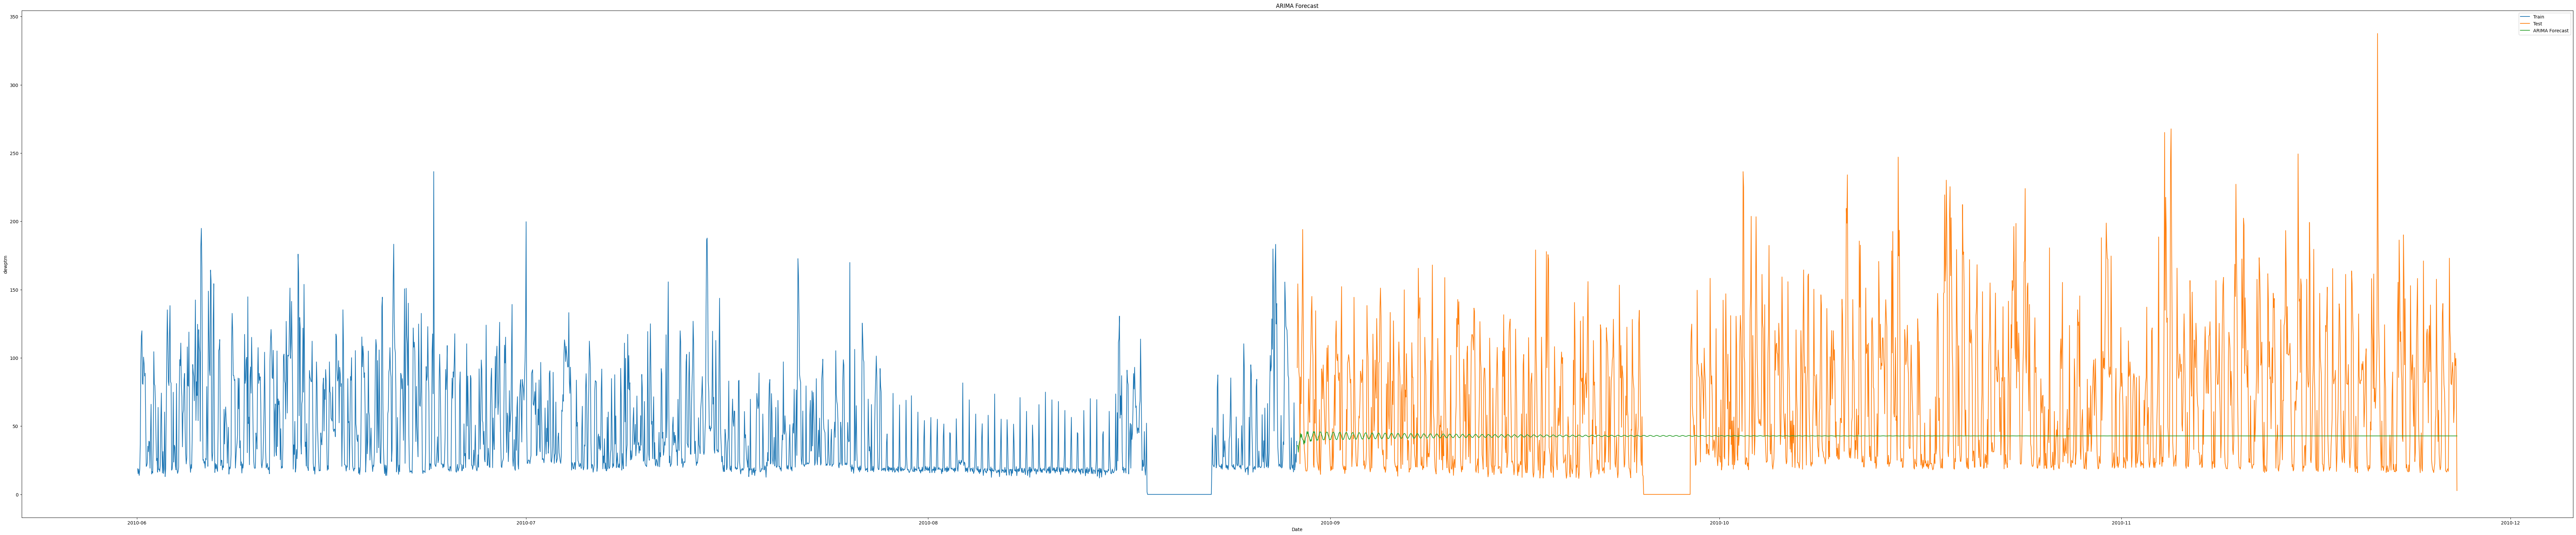

In [21]:
plt.figure(figsize=(100, 20))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predicted_mean, label='ARIMA Forecast')
# plt.fill_between(forecast.conf_int().index,
#                  forecast.conf_int().iloc[:, 0],
#                  forecast.conf_int().iloc[:, 1], color='k', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('dewptm')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

# **QLSTM MODEL**

In [22]:
ARIMA_Result =  pd.DataFrame(columns=['raw', 'predicted','residuals'])
ARIMA_Result['raw'] = test_data['Global_active_power'].copy()
ARIMA_Result['predicted'] = predicted_mean.to_numpy()
ARIMA_Result['residuals'] = ARIMA_Result['raw'] - ARIMA_Result['predicted']
std_residuals = ARIMA_Result['residuals'].std()
ARIMA_Result['std_residuals'] = ARIMA_Result['residuals'] / std_residuals
ARIMA_Result['nxt_target'] = ARIMA_Result['residuals'].shift(-1)
ARIMA_Result['nxt_target'][len(ARIMA_Result)-1] = ARIMA_Result['nxt_target'][len(ARIMA_Result)-2]
ARIMA_Result

/tmp/ipykernel_57073/2497880966.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ARIMA_Result['nxt_target'][len(ARIMA_Result)-1] = ARIMA_Result['nxt_target'][len(ARIMA_Result)-2]
/tmp/ipykernel_57073/2497880966.py:8: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ARIMA_Result['nxt_target'][len(ARIMA_Result)-1] = ARIMA_Result['nxt_target'][len(ARIMA_Result)-2]


raw  predicted   residuals  std_residuals  nxt_target
datetime                                                                      
2010-08-29 11:00:00   92.840  35.707029   57.132971       1.192529  118.404229
2010-08-29 12:00:00  154.224  35.819771  118.404229       2.471435   95.869590
2010-08-29 13:00:00  126.834  30.964410   95.869590       2.001073   54.031877
2010-08-29 14:00:00   90.128  36.096123   54.031877       1.127800   46.565711
2010-08-29 15:00:00   85.162  38.596289   46.565711       0.971960  -17.242023
...                      ...        ...         ...            ...         ...
2010-11-26 17:00:00  103.554  42.841256   60.712744       1.267249   51.567382
2010-11-26 18:00:00   94.408  42.840618   51.567382       1.076359   56.719368
2010-11-26 19:00:00   99.560  42.840632   56.719368       1.183896   26.980713
2010-11-26 20:00:00   69.822  42.841287   26.980713       0.563165  -40.038405
2010-11-26 21:00:00    2.804  42.842405  -40.038405      -0.835716  -40.038405

[2147 rows x 5 columns]

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time

In [24]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:]) 
    data = scaler2.fit_transform(data.iloc[:,:1])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [25]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 2
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 1
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [26]:
size = int(len(ARIMA_Result) * 0.5)

train = ARIMA_Result[['residuals','nxt_target']][:size].copy()
test = ARIMA_Result[['residuals','nxt_target']][size:].copy()

In [27]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [28]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [29]:
class QLSTM(nn.Module):
    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]

            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

class QRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [30]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = QRegressionLSTM(num_sensors=1, hidden_units= 6, n_qubits=1)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

weight_shapes = (n_qlayers, n_qubits) = (1, 1)


In [31]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)

count = 0
for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)}')

[1/5]  LossQ:257.46255472511984
[2/5]  LossQ:253.49638321995735
[3/5]  LossQ:247.81847052345984
[4/5]  LossQ:241.45960860489868
[5/5]  LossQ:236.62131357053295


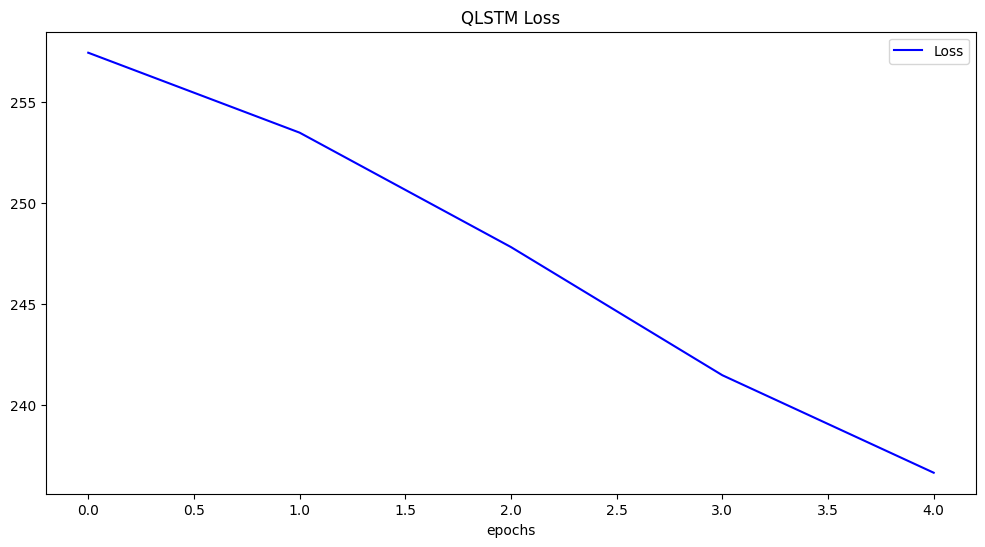

In [32]:
np.savetxt('./SavedModels/Electricity/household_power_consump/loss/arima_qlstm.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [33]:
histQ1 = histQ 

In [34]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)


    return output

In [35]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)

print(pred_y_train)

tensor([ 0.4836,  0.6183,  0.4999,  ..., -0.0672, -0.0667, -0.1193],
       grad_fn=<ViewBackward0>)


In [36]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)
pred_y_train

tensor([[ 0.4836],
        [ 0.6183],
        [ 0.4999],
        ...,
        [-0.0672],
        [-0.0667],
        [-0.1193]], grad_fn=<ViewBackward0>)

In [37]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [38]:
np.savetxt('./SavedModels/Electricity/household_power_consump/train/arima_qlstm.txt',y_train_pred)
np.savetxt('./SavedModels/Electricity/household_power_consump/test/arima_qlstm.txt',y_test_pred)

Training dataset MSE: 1714.64621994817 RMSE:41.40828685116266


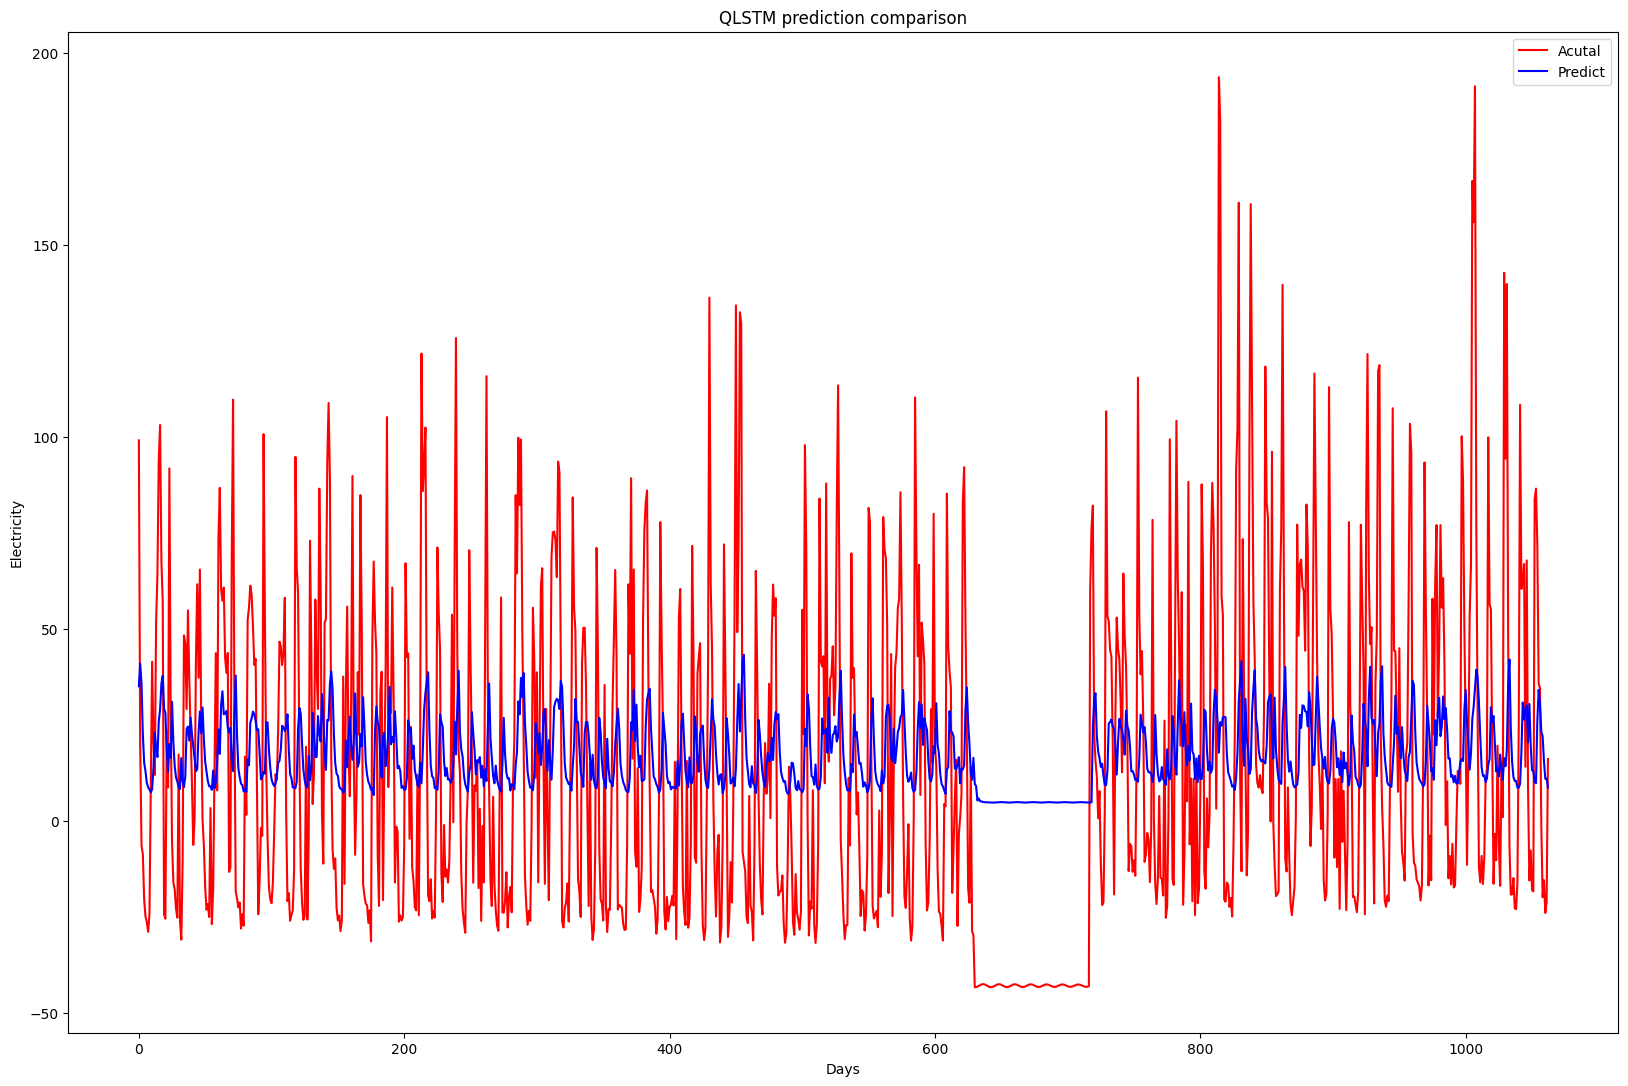

In [39]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('Electricity')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset MSE: {MSE} RMSE:{RMSE}')

Training dataset MSE:2358.1965346690977 RMSE:48.561265785285066


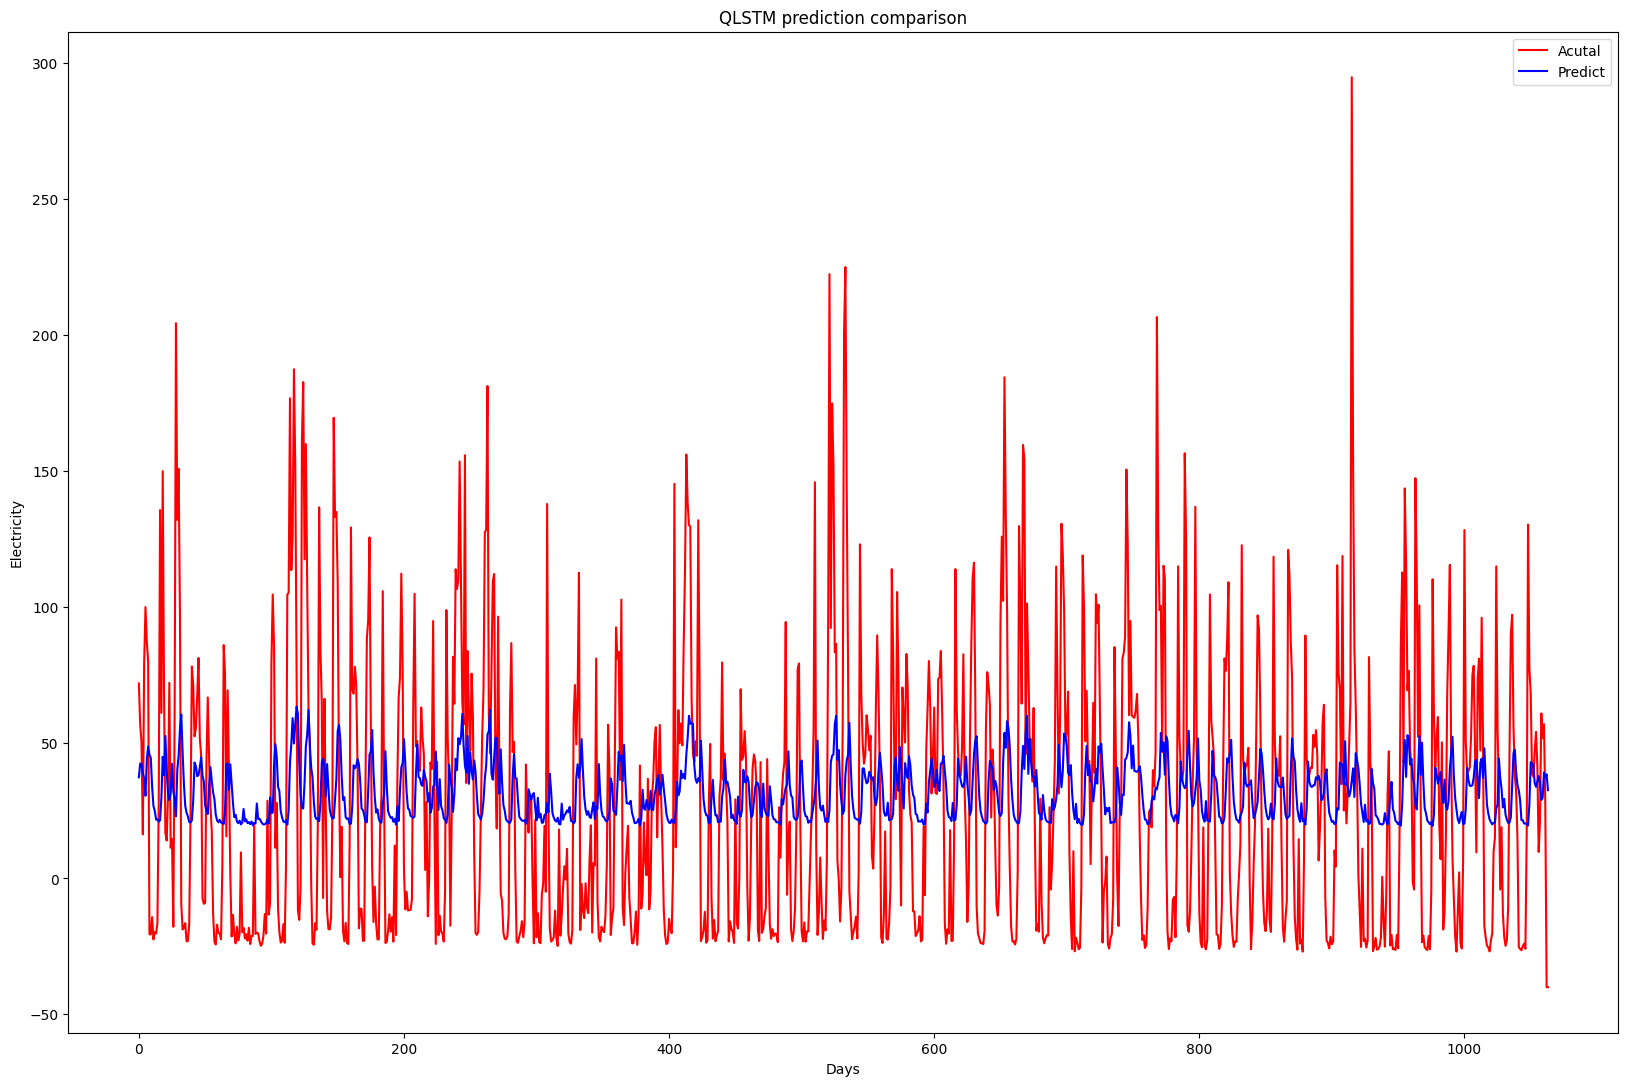

In [40]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('Electricity')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset MSE:{MSE} RMSE:{RMSE}')

In [41]:
final_result_qlstm = ARIMA_Result['predicted'][size+window_size:].values + y_test_pred.squeeze(1)

In [42]:
frq = ARIMA_Result[['predicted','raw']][size+window_size:].copy()
frq['final'] = final_result_qlstm
frq

predicted      raw      final
datetime                                          
2010-10-13 14:00:00  42.917868  114.630  80.108073
2010-10-13 15:00:00  42.933267  114.678  85.207040
2010-10-13 16:00:00  42.924344   99.666  85.035412
2010-10-13 17:00:00  42.893659   92.946  81.570035
2010-10-13 18:00:00  42.849593   59.074  79.712134
...                        ...      ...        ...
2010-11-26 17:00:00  42.841256  103.554  72.499199
2010-11-26 18:00:00  42.840618   94.408  81.749077
2010-11-26 19:00:00  42.840632   99.560  80.034907
2010-11-26 20:00:00  42.841287   69.822  81.137247
2010-11-26 21:00:00  42.842405    2.804  75.317839

[1064 rows x 3 columns]

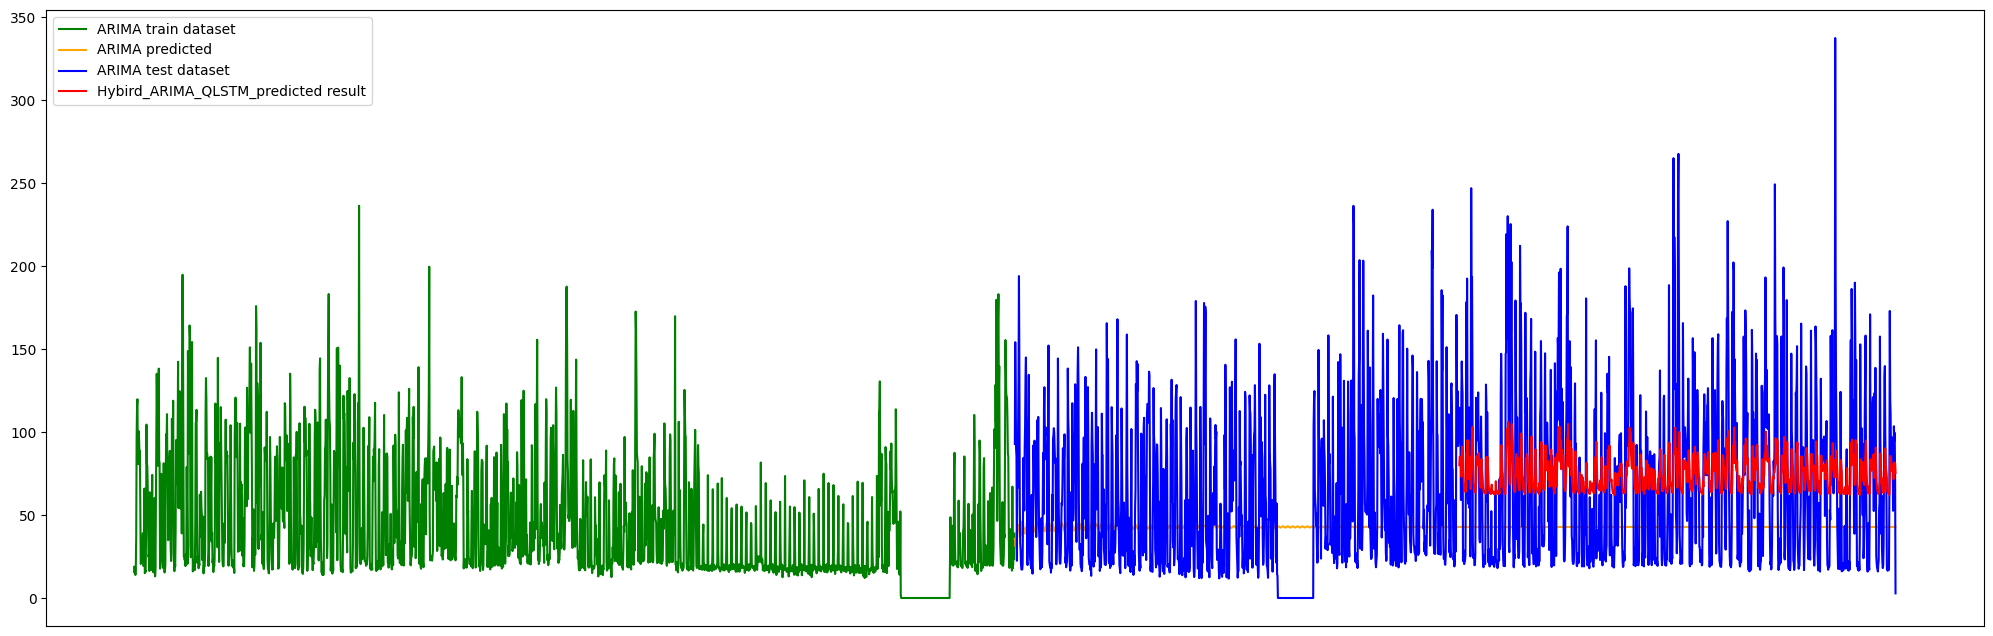

In [43]:
plt.figure(figsize=(25,8))
plt.plot(train_data['Global_active_power'], label ='ARIMA train dataset', color='green')
plt.plot(ARIMA_Result['predicted'], label ='ARIMA predicted', color='orange')
plt.plot(ARIMA_Result['raw'], label = "ARIMA test dataset", color ='blue')
plt.plot(frq['final'], label = 'Hybird_ARIMA_QLSTM_predicted result', color='red')
#plt.axvline(x=len(train_data['Global_active_power']), c='black', linestyle='--')
#plt.axvline(x=len(train_data['Global_active_power']) + len(ARIMA_Result['predicted']) - len(frq['final']), c='black', linestyle='--')
plt.gca().set_xticks([])
plt.plot()
plt.legend()
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(final_result_qlstm,ARIMA_Result['raw'][size+window_size:].values )    
mae = mean_absolute_error(final_result_qlstm, ARIMA_Result['raw'][size+window_size:].values)
rmse = np.sqrt(mse)

print(f'X_test MSE: {mse}')
print(f'X_test MAE: {mae}')
print(f'X_test RMSE: {rmse}')

X_test MSE: 2076.6477022128342
X_test MAE: 36.81138038164855
X_test RMSE: 45.570250188174676


In [45]:
torch.save(modelQ.state_dict(),'./SavedModels/Electricity/household_power_consump/model/arima_QLSTM_sd')

# **LSTM MODEL**

In [46]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [47]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = ShallowRegressionLSTM(num_sensors=1, hidden_units=6)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

In [48]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)

count = 0
for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

[1/5]  LossQ:237.8051508050412 
[2/5]  LossQ:202.75294815557572 
[3/5]  LossQ:195.62196416733423 
[4/5]  LossQ:193.97042342777968 
[5/5]  LossQ:192.8621850777963 


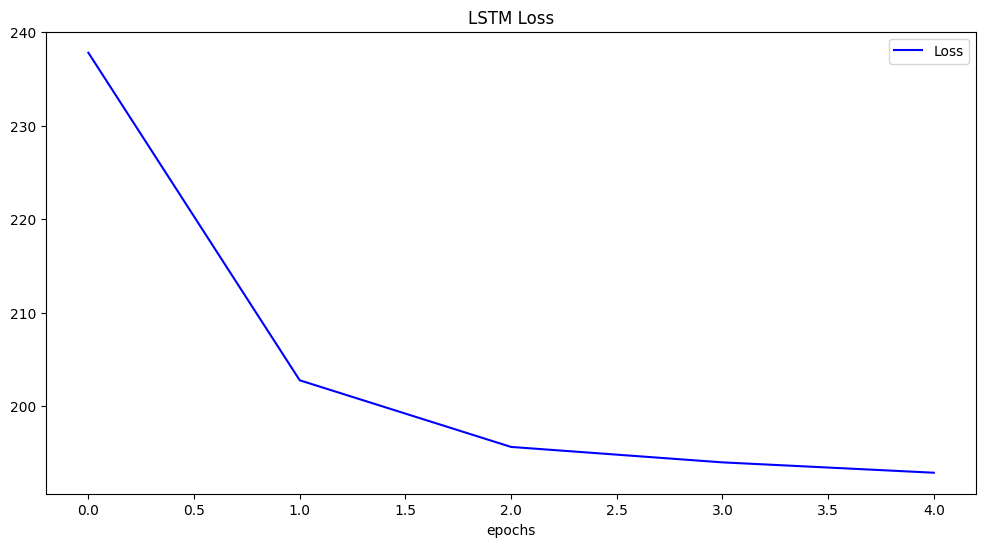

In [49]:
np.savetxt('./SavedModels/Electricity/household_power_consump/loss/arima_lstm.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('LSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [50]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)

In [51]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [52]:
np.savetxt('./SavedModels/Electricity/household_power_consump/train/arima_lstm.txt',y_train_pred)
np.savetxt('./SavedModels/Electricity/household_power_consump/test/arima_lstm.txt',y_test_pred)

Training dataset MSE: 1892.8506311684637 RMSE:43.50690325877566


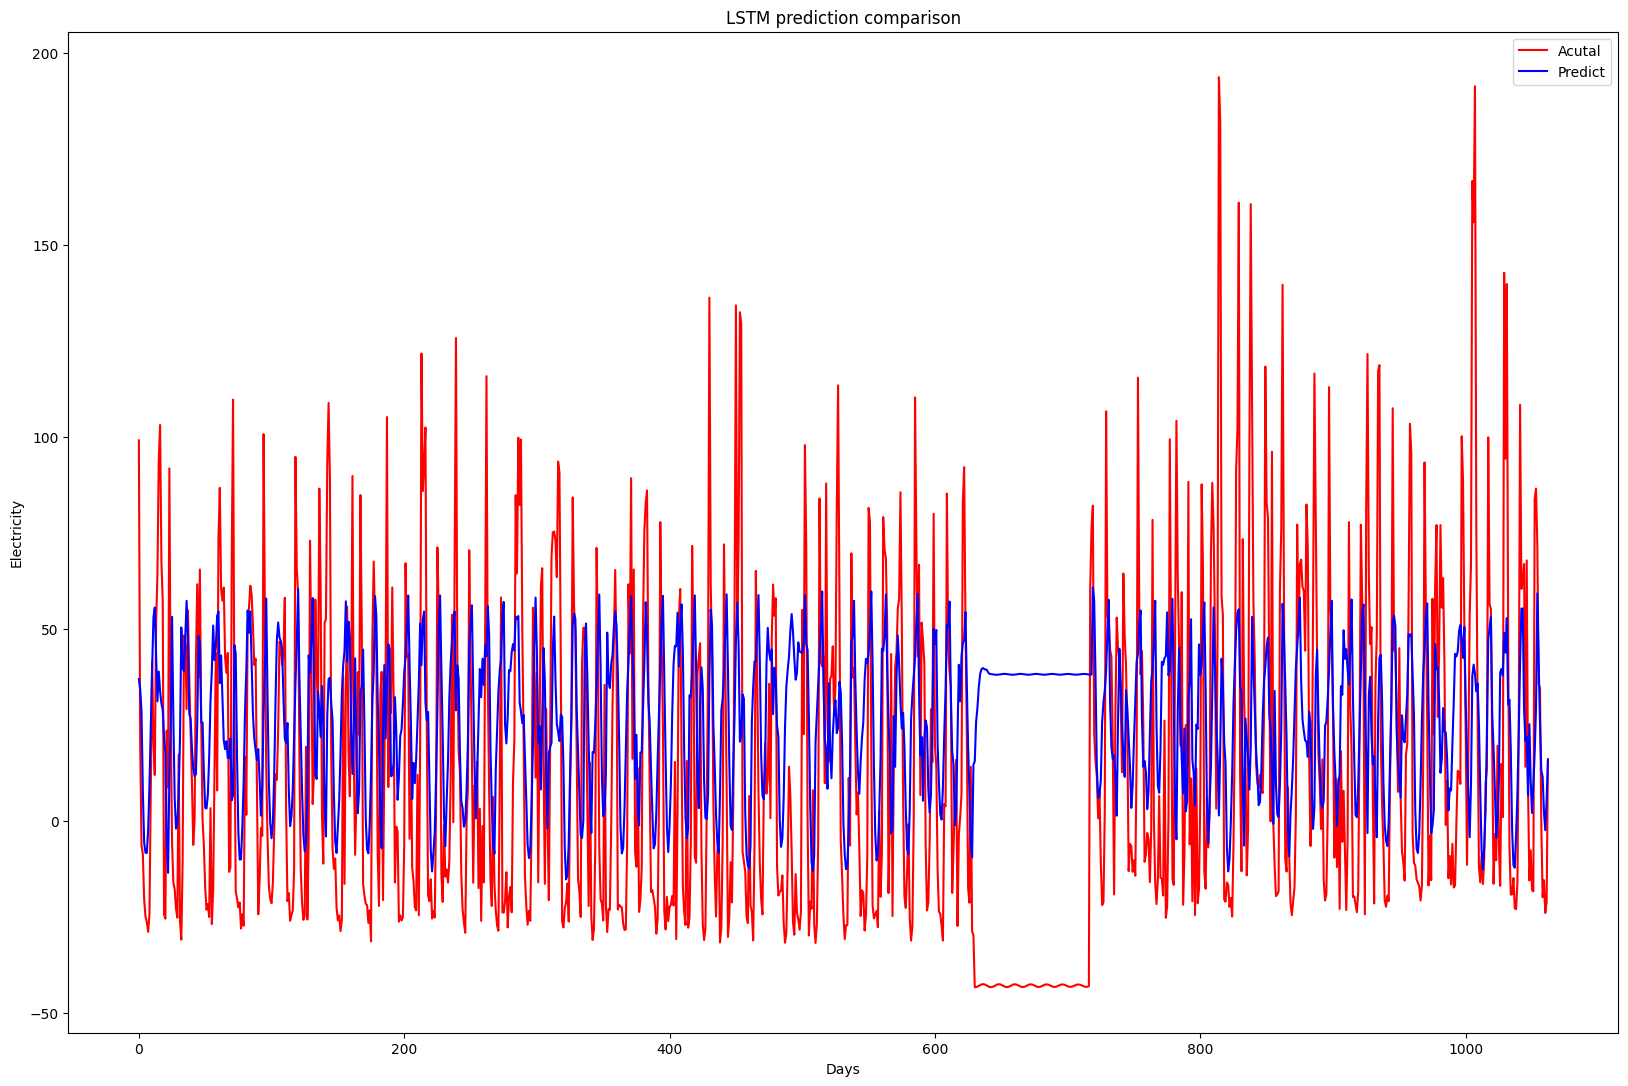

In [53]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('LSTM prediction comparison')
plt.ylabel('Electricity')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset MSE: {MSE} RMSE:{RMSE}')

Training dataset RMSE:50.83039276910894


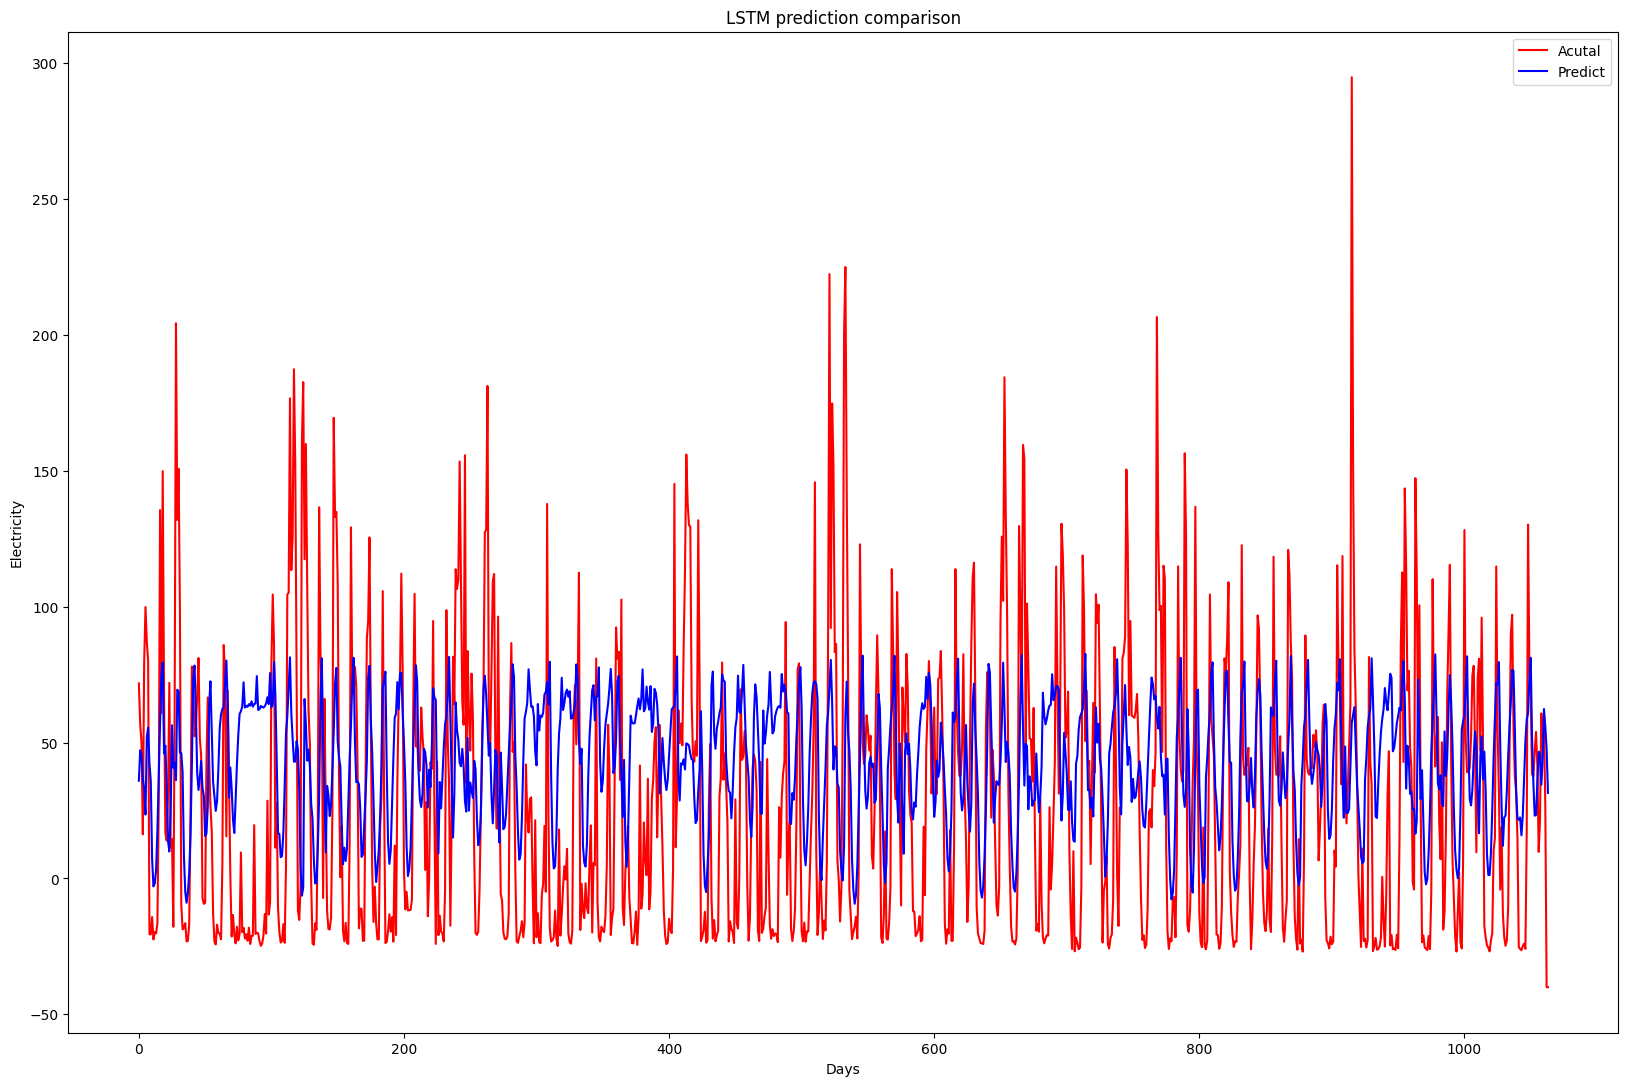

In [54]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('LSTM prediction comparison')
plt.ylabel('Electricity')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [55]:
final_result= ARIMA_Result['predicted'][size+window_size:].values + y_test_pred.squeeze(1)

In [56]:
fr = ARIMA_Result[['predicted','raw']][size+window_size:].copy()
fr['final'] = final_result
fr

predicted      raw       final
datetime                                           
2010-10-13 14:00:00  42.917868  114.630   78.857012
2010-10-13 15:00:00  42.933267  114.678   90.079663
2010-10-13 16:00:00  42.924344   99.666   88.592526
2010-10-13 17:00:00  42.893659   92.946   79.451875
2010-10-13 18:00:00  42.849593   59.074   75.758319
...                        ...      ...         ...
2010-11-26 17:00:00  42.841256  103.554   86.245407
2010-11-26 18:00:00  42.840618   94.408  105.149781
2010-11-26 19:00:00  42.840632   99.560   98.657641
2010-11-26 20:00:00  42.841287   69.822   90.372686
2010-11-26 21:00:00  42.842405    2.804   74.296015

[1064 rows x 3 columns]

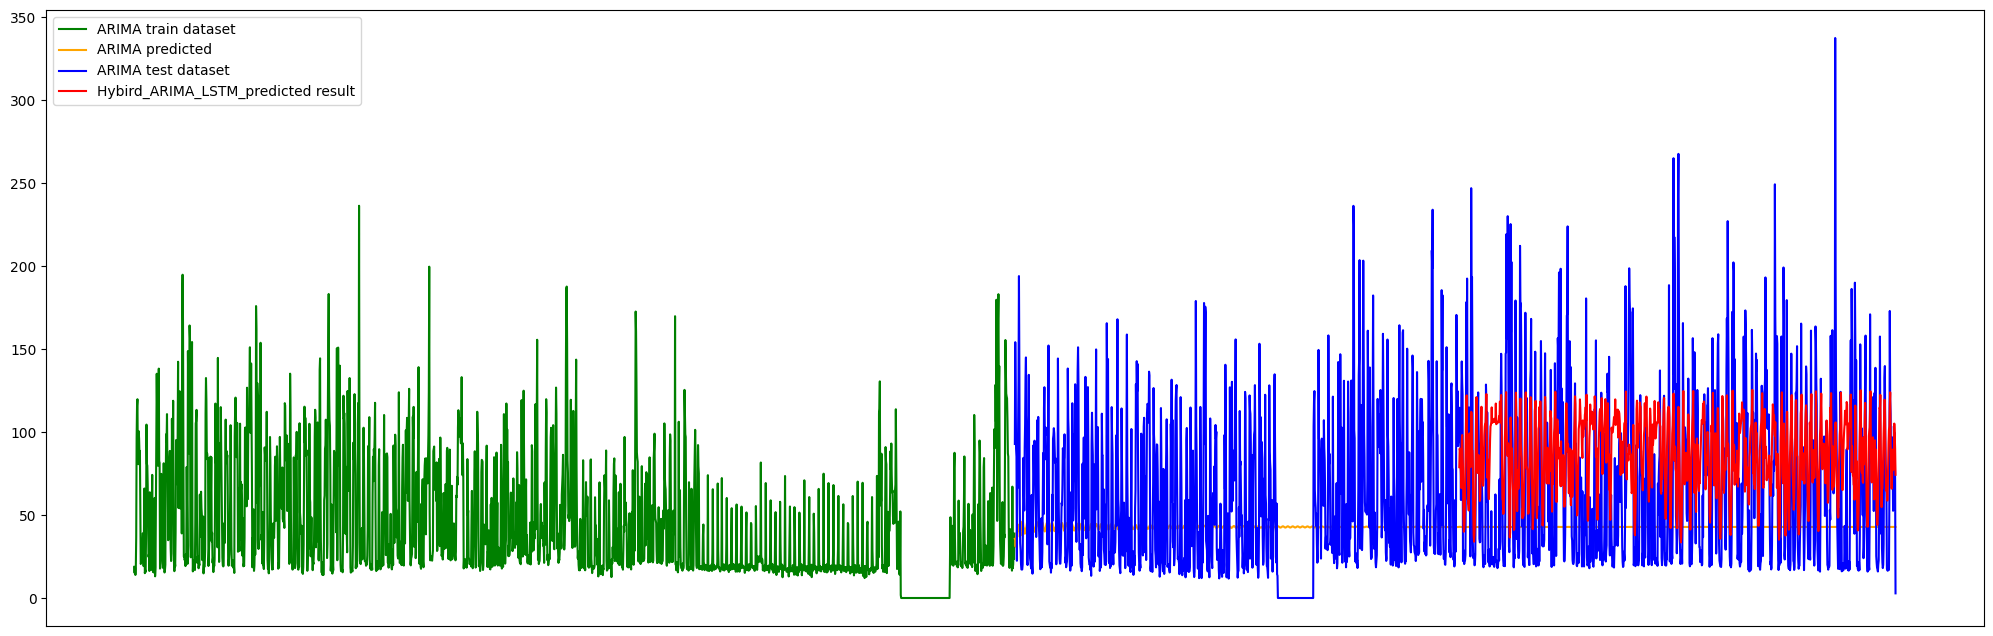

In [57]:
plt.figure(figsize=(25,8))
plt.plot(train_data['Global_active_power'], label ='ARIMA train dataset', color='green')
plt.plot(ARIMA_Result['predicted'], label ='ARIMA predicted', color='orange')
plt.plot(ARIMA_Result['raw'], label = "ARIMA test dataset", color ='blue')
plt.plot(fr['final'], label = 'Hybird_ARIMA_LSTM_predicted result', color='red')
#plt.axvline(x=len(train_data['Global_active_power']), c='black', linestyle='--')
#plt.axvline(x=len(train_data['Global_active_power']) + len(ARIMA_Result['predicted']) - len(frq['final']), c='black', linestyle='--')
plt.gca().set_xticks([])
plt.plot()
plt.legend()
plt.show()

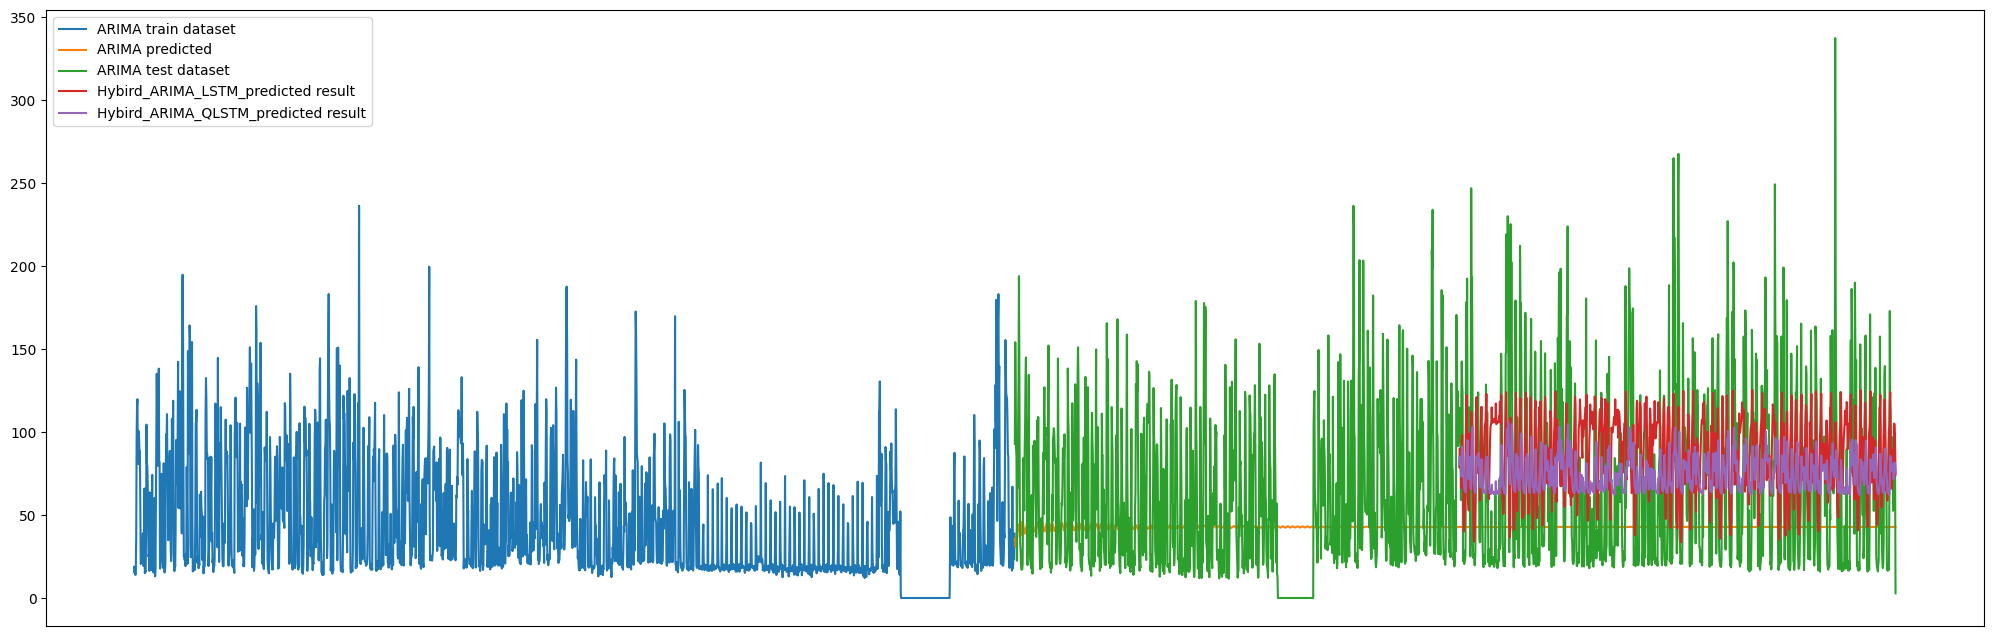

In [58]:
plt.figure(figsize=(25,8))
plt.plot(train_data['Global_active_power'], label ='ARIMA train dataset')
plt.plot(ARIMA_Result['predicted'], label ='ARIMA predicted')
plt.plot(ARIMA_Result['raw'], label = "ARIMA test dataset")
plt.plot(fr['final'], label = 'Hybird_ARIMA_LSTM_predicted result')
plt.plot(frq['final'], label = 'Hybird_ARIMA_QLSTM_predicted result')
#plt.axvline(x=len(train_data['Global_active_power']), c='black', linestyle='--')
#plt.axvline(x=len(train_data['Global_active_power']) + len(ARIMA_Result['predicted']) - len(frq['final']), c='black', linestyle='--')
plt.gca().set_xticks([])
plt.plot()
plt.legend()
plt.show()

In [59]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(final_result,ARIMA_Result['raw'][size+window_size:].values )    
mae = mean_absolute_error(final_result, ARIMA_Result['raw'][size+window_size:].values)
rmse = np.sqrt(mse)

print(f'X_test MSE: {mse}')
print(f'X_test MAE: {mae}')
print(f'X_test RMSE: {rmse}')

X_test MSE: 2515.8490957991994
X_test MAE: 40.80562206379881
X_test RMSE: 50.1582405572524


In [60]:
torch.save(modelQ,'./SavedModels/Electricity/household_power_consump/model/arima_lstm')

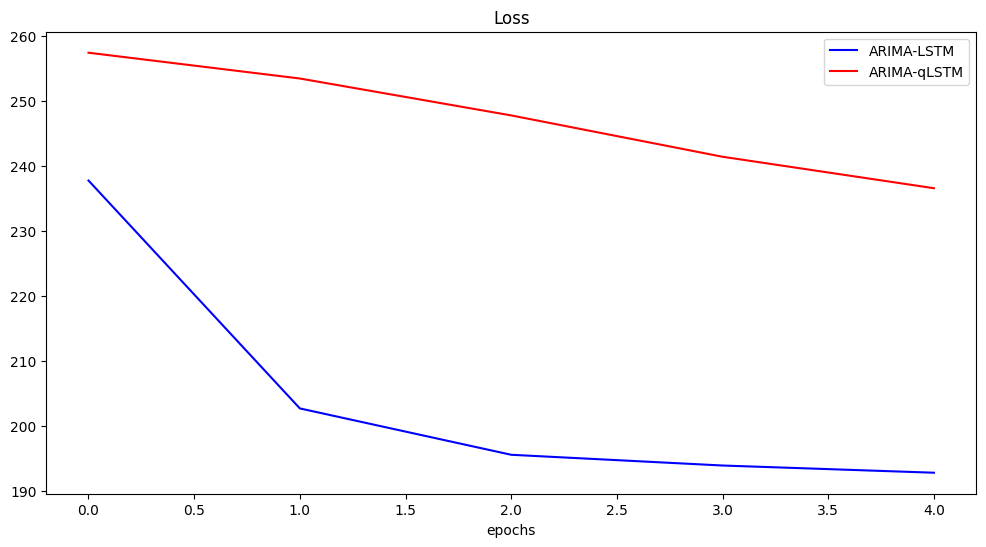

In [61]:
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'ARIMA-LSTM')
plt.plot(histQ1, color='red', label='ARIMA-qLSTM')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')